<a href="https://colab.research.google.com/github/Birkbeck/msc-projects-2023-4-Gabriele_Monti_PEFT/blob/main/intrinsic_dimension_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This notebook demonstrates the concept of intrinsic dimensionality and its application in reducing the number of trainable parameters in large language models. By using the Fastfood transform and pruning techniques, we aim to show how computational requirements can be significantly decreased without compromising model performance. The notebook includes experiments with the `xlm-roberta-base` model, showcasing the impact of parameter reduction on inference time and accuracy using the Wikitext dataset.

---

In [1]:
#load the embeddings of the BERT Model
from transformers import BertModel

model = BertModel.from_pretrained("bert-base-uncased")
embedding_matrix = model.embeddings.word_embeddings.weight

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [6]:
#paramters of the fastfood tranform are created and applied to the embedding matrix

import numpy as np
from scipy.linalg import hadamard

# Generate Fastfood parameters
def generate_fastfood_parameters(d):
    # B is a diagonal matrix with entries ±1
    B = np.random.choice([1, -1], size=d)

    # G is a diagonal matrix with entries drawn from a normal distribution
    G = np.random.randn(d)

    # S is a diagonal matrix with entries drawn from a normal distribution
    S = np.random.randn(d)

    # Pi is a random permutation matrix
    Pi = np.random.permutation(d)

    return B, G, S, Pi

# Fast Walsh-Hadamard Transform
def fast_walsh_hadamard_transform(x):
    # Generate the Hadamard matrix of size len(x)
    H = hadamard(len(x))

    # Perform the matrix multiplication H * x
    return H @ x

# Fastfood transform function
def fastfood_transform(x, B, G, S, Pi):
    d = len(x)

    # Step 1: Element-wise multiplication of B and x
    Bx = B * x

    # Step 2: Element-wise multiplication of G and Bx
    G_Bx = G * Bx

    # Step 3: Apply the permutation Pi
    Pi_G_Bx = G_Bx[Pi]

    # Step 4: Apply the Hadamard transform
    H_Pi_G_Bx = fast_walsh_hadamard_transform(Pi_G_Bx)

    # Step 5: Scale by 1/sqrt(d) and element-wise multiply by S
    return (1 / np.sqrt(d)) * S * H_Pi_G_Bx

# Apply Fastfood transform to a matrix
def apply_fastfood_to_matrix(matrix):
    d = matrix.shape[1]

    # Calculate the next power of 2 greater than or equal to d
    next_power_of_2 = 2**int(np.ceil(np.log2(d)))

    # Pad the matrix with zeros to make the number of columns a power of 2
    padded_matrix = np.pad(matrix, ((0, 0), (0, next_power_of_2 - d)), 'constant')

    # Generate Fastfood parameters for the padded size
    B, G, S, Pi = generate_fastfood_parameters(next_power_of_2)

    # Initialize the transformed matrix with zeros
    transformed_matrix = np.zeros_like(padded_matrix)

    # Apply Fastfood transform to each row of the padded matrix
    for i in range(padded_matrix.shape[0]):
        transformed_matrix[i] = fastfood_transform(padded_matrix[i], B, G, S, Pi)

    # Remove the padding to restore the original dimensions
    return transformed_matrix[:, :d]

# Create a large random matrix (1000 x 1000) with entries drawn from a normal distribution
#large_matrix = np.random.randn(1000, 1000)

# Apply Fastfood transform to the large matrix
#transformed_matrix = apply_fastfood_to_matrix(large_matrix)

embedding_matrix_np = embedding_matrix.detach().numpy()
transformed_matrix = apply_fastfood_to_matrix(embedding_matrix_np)


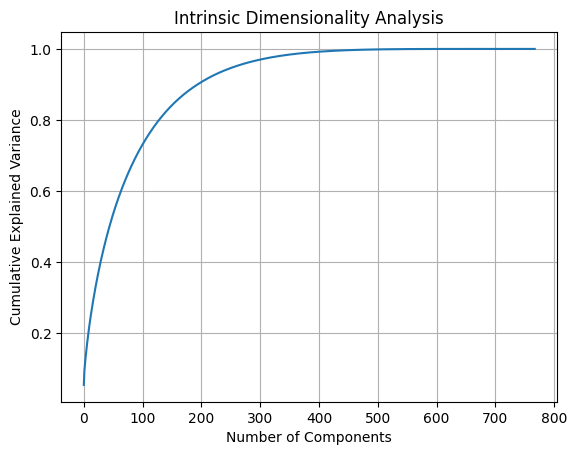

258

In [7]:

#PCA is applied to the tranform matrix and plotted


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def analyze_intrinsic_dimensionality(matrix):
    pca = PCA()
    pca.fit(matrix)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    plt.plot(explained_variance)
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Intrinsic Dimensionality Analysis')
    plt.grid(True)
    plt.show()

    # Determine the number of components that explain at least 95% of the variance
    intrinsic_dimensionality = np.argmax(explained_variance >= 0.95) + 1
    return intrinsic_dimensionality

intrinsic_dimensionality = analyze_intrinsic_dimensionality(transformed_matrix)
intrinsic_dimensionality


In [8]:
#inference test with the text pruner to see how inference time is affected by pruning

!pip install textpruner

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nv

In [1]:
#load and import the libary

import textpruner
from transformers import XLMRobertaForSequenceClassification,XLMRobertaTokenizer

from textpruner import summary, TransformerPruner
import sys

from transformers import AutoTokenizer, AutoModelForMaskedLM,XLMModel

tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
#test inference on the untouche model

token =tokenizer("Hello, i am looking <mask> Jammie",return_tensors="pt")

# model.device("cpu")
inference = textpruner.inference_time(model,token)
print
print(inference)

cpu-repetitions: 100%|██████████| 10/10 [00:04<00:00,  2.11it/s]

Device: cpu
Mean inference time: 467.18ms
Standard deviation: 160.88ms
(467.182666015625, 160.87646484375)


In [3]:
#check the paramters before and after pruning

print("Before pruning:")
print(summary(model))


pruner = TransformerPruner(model)

ffn_mask = textpruner.pruners.utils.random_mask_tensor((12,3072))
head_mask = textpruner.pruners.utils.random_mask_tensor((12,12), even_masks=False)


pruner.prune(head_mask=head_mask, ffn_mask=ffn_mask,save_model=True)

print("After pruning:")
print(summary(model))

for i in range(12):
    print ((model.base_model.encoder.layer[i].intermediate.dense.weight.shape,
            model.base_model.encoder.layer[i].intermediate.dense.bias.shape,
            model.base_model.encoder.layer[i].attention.self.key.weight.shape))


token =tokenizer("Hello, i am looking <mask> Jammie",return_tensors="pt")

# model.device("cpu")
inference = textpruner.inference_time(model,token)
print(inference)

Before pruning:

LAYER NAME                    	        #PARAMS	     RATIO	 MEM(MB)
--model:                      	    278,295,186	   100.00%	 1061.61
  --roberta:                  	    277,453,056	    99.70%	 1058.40
    --embeddings:             	    192,398,592	    69.13%	  733.94
    --encoder:                	     85,054,464	    30.56%	  324.46
  --lm_head(partially shared):	        842,130	     0.30%	    3.21
    --bias:                   	        250,002	     0.09%	    0.95
    --dense:                  	        590,592	     0.21%	    2.25
    --layer_norm:             	          1,536	     0.00%	    0.01
    --decoder(shared):        	              0	     0.00%	    0.00

After pruning:

LAYER NAME                    	        #PARAMS	     RATIO	 MEM(MB)
--model:                      	    235,598,802	   100.00%	  898.74
  --roberta:                  	    234,756,672	    99.64%	  895.53
    --embeddings:             	    192,398,592	    81.66%	  733.94
    --encoder:              

cpu-repetitions: 100%|██████████| 10/10 [00:03<00:00,  3.12it/s]

Device: cpu
Mean inference time: 315.80ms
Standard deviation: 19.75ms
(315.802880859375, 19.747997283935547)


In [4]:
#check the inference time after pruning

token =tokenizer("Hello, i am looking <mask> Jammie",return_tensors="pt")

# model.device("cpu")
inference = textpruner.inference_time(model,token)
print
print(inference)

cpu-repetitions: 100%|██████████| 10/10 [00:03<00:00,  3.11it/s]

Device: cpu
Mean inference time: 316.74ms
Standard deviation: 16.79ms
(316.7355224609375, 16.78974723815918)


In [8]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
     

In [7]:
#untouched model xlm-roberta-base test for inference time and output tokens

import torch
import time
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Tokenize the input text
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base")

token = tokenizer("Dear <mask>, thank you for your", return_tensors="pt")

# Perform inference to get logits
start_time = time.time()  # Start the timer

with torch.no_grad():
    output = model(**token)
    logits = output.logits

end_time = time.time()  # End the timer
inference_time = end_time - start_time  # Calculate the inference time

print(f"Inference time: {inference_time:.4f} seconds")

# Find the index of the mask token
mask_token_index = torch.where(token["input_ids"] == tokenizer.mask_token_id)[1]

# Get the logits for the mask token
mask_token_logits = logits[0, mask_token_index, :]

# Get the top 5 token predictions for the mask
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()
print("Top 5 token IDs:", top_5_tokens)

# Decode and print the top 5 predictions
print("Top 5 predictions for the masked token:")
for token_id in top_5_tokens:
    predicted_token = tokenizer.decode([token_id])
    print(f"Predicted token: {predicted_token}")


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Inference time: 0.2803 seconds
Top 5 token IDs: [10868, 18022, 83054, 11617, 61443]
Top 5 predictions for the masked token:
Predicted token: Sir
Predicted token: admin
Predicted token: Guest
Predicted token: Michael
Predicted token: Admin


In [1]:
#pruning functions applied to the attention layers

import torch
import torch.nn.utils.prune as prune
from transformers import AutoModelForMaskedLM, AutoTokenizer

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base")

# Move the model to CPU
model.to("cpu")

# Function to count total parameters
def count_total_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

# Function to count non-zero parameters
def count_non_zero_parameters(model):
    non_zero_params = sum(torch.count_nonzero(p).item() for p in model.parameters() if p.requires_grad)
    return non_zero_params

# Count parameters before pruning
total_params_before = count_total_parameters(model)
non_zero_params_before = count_non_zero_parameters(model)

# Prune the attention heads
def prune_attention_heads(model, amount=0.1):
    """
    Prune the attention heads in the model.
    Args:
        model (nn.Module): The model to prune.
        amount (float): The proportion of connections to prune.
    """
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)
            prune.l1_unstructured(module, name='bias', amount=amount)

def prune_model_attention(model, amount=0.1):
    """
    Prune the attention heads of the entire model.
    Args:
        model (nn.Module): The model to prune.
        amount (float): The proportion of connections to prune.
    """
    for name, module in model.named_modules():
        if 'attention.self' in name and isinstance(module, torch.nn.Linear):
            prune_attention_heads(module, amount)


# Apply pruning
prune_model_attention(model, amount=0.1)

# Function to apply the pruning and remove the original parameters
def apply_pruning(model):
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            # Check if the parameter has been pruned
            if hasattr(module, 'weight_orig'):
                prune.remove(module, 'weight')
            if hasattr(module, 'bias_orig'):
                prune.remove(module, 'bias')

# Apply the pruning
apply_pruning(model)

# Count parameters after pruning
total_params_after = count_total_parameters(model)
non_zero_params_after = count_non_zero_parameters(model)

# Print the results
print("Total parameters before pruning:", total_params_before)
print("Non-zero parameters before pruning:", non_zero_params_before)
print("Total parameters after pruning:", total_params_after)
print("Non-zero parameters after pruning:", non_zero_params_after)
print ("diffrence = ",non_zero_params_before-non_zero_params_after)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM

Total parameters before pruning: 278295186
Non-zero parameters before pruning: 278293470
Total parameters after pruning: 278295186
Non-zero parameters after pruning: 276167440
diffrence =  2126030


In [3]:
# infrence of the pruned model and inference time
import time
token = tokenizer("Dear <mask>, thank you for your", return_tensors="pt")

start_time = time.time()

# Perform inference to get logits
with torch.no_grad():
    output = model(**token)
    logits = output.logits


end_time = time.time()  # End the timer
inference_time = end_time - start_time  # Calculate the inference time


print("Inference output logits:")
print(logits)


print(f"Inference time: {inference_time:.4f} seconds")


# Find the index of the mask token
mask_token_index = torch.where(token["input_ids"] == tokenizer.mask_token_id)[1]

# Get the logits for the mask token
mask_token_logits = logits[0, mask_token_index, :]

# Get the top 5 token predictions for the mask
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()
print("Top 5 token IDs:", top_5_tokens)

# Decode and print the top 5 predictions
print("Top 5 predictions for the masked token:")
for token_id in top_5_tokens:
    predicted_token = tokenizer.decode([token_id])
    print(f"Predicted token: {predicted_token}")


Inference output logits:
tensor([[[68.2479,  0.1338, 40.9037,  ..., 18.4577, 14.2758, 19.2053],
         [25.3799, -1.0565, 55.9010,  ..., 31.8812, 16.0895, 28.7202],
         [22.6723, -1.4275, 57.7912,  ..., 47.5638, 18.9308, 31.6662],
         ...,
         [25.9127, -1.2768, 56.0895,  ..., 40.6655, 16.6856, 29.8830],
         [21.6050, -1.3091, 52.6704,  ..., 34.7724, 14.6927, 28.1345],
         [24.7923, -0.3563, 58.5146,  ..., 29.4959, 17.5336, 26.3214]]])
Inference time: 1.3462 seconds
Top 5 token IDs: [10868, 18022, 61443, 83054, 7948]
Top 5 predictions for the masked token:
Predicted token: Sir
Predicted token: admin
Predicted token: Admin
Predicted token: Guest
Predicted token: Peter


In [4]:
#pruned model accuracy test
import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer
from datasets import load_dataset

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")


# Function to evaluate the model on a test dataset
def evaluate_model(model, tokenizer, test_dataset, max_length=512):
    model.eval()
    total_loss = 0
    count = 0

    with torch.no_grad():
        for example in test_dataset:
            inputs = tokenizer(example["text"], return_tensors="pt", max_length=max_length, truncation=True, padding="max_length")
            inputs = inputs.to(model.device)

            labels = inputs.input_ids.clone()
            outputs = model(**inputs, labels=labels)
            loss = outputs.loss

            total_loss += loss.item()
            count += 1

    avg_loss = total_loss / count
    return avg_loss

# Load the test dataset
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test[:1%]")  # Using only 1% of the dataset for quick evaluation

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluate the model
test_loss = evaluate_model(model, tokenizer, dataset)

# Print the test loss
print("Pruned Test Loss:", test_loss)


Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Pruned Test Loss: 48.53918920863759


In [5]:
#untouched model accuracy test
import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer
from datasets import load_dataset

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
model = AutoModelForMaskedLM.from_pretrained("xlm-roberta-base")

# Function to evaluate the model on a test dataset
def evaluate_model(model, tokenizer, test_dataset, max_length=512):
    model.eval()
    total_loss = 0
    count = 0

    with torch.no_grad():
        for example in test_dataset:
            inputs = tokenizer(example["text"], return_tensors="pt", max_length=max_length, truncation=True, padding="max_length")
            inputs = inputs.to(model.device)

            labels = inputs.input_ids.clone()
            outputs = model(**inputs, labels=labels)
            loss = outputs.loss

            total_loss += loss.item()
            count += 1

    avg_loss = total_loss / count
    return avg_loss

# Load the test dataset
dataset = load_dataset("wikitext", "wikitext-2-raw-v1", split="test[:1%]")  # Using only 1% of the dataset for quick evaluation

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Evaluate the model
test_loss = evaluate_model(model, tokenizer, dataset)

# Print the test loss
print("unoutuched Test Loss:", test_loss)


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


unoutuched Test Loss: 46.55001003091986
